# Lassie as retrieval tool

This demo explores how the [Lassie](https://github.com/filecoin-project/lassie) tool extends the utility to retrieve data from the IPFS ecosystem.  
Compared to the IPFS tools (including Kubo CLI and IPFS desktop) used in the [previous demo](https://easierdata.org/notebooks/ndvi_stac_ipfs), the Lassie tool has following features that are different from the IPFS tools and potentially make it a better choice for data retrieval.
- Easy installation: For Lassie, the binary executable is the only tool to install while an IPFS or Filecoin daemon is not needed for online retrieval; The Kubo tool requires a daemon running background in order to retrieve files from non-local nodes.
- Filecoin compatibility: The tool is designed to fetch files from the best protocol, e.g., IPFS layer and Filecoin layer; Kubo tool can only fetch files from the IPFS node network.
- Crossover tool via HTTP daemon: The tool can start an HTTP server to fetch content over HTTP so it can be easy to use in any programming language; Kubo CLI doesn't have an Python-based package and requires using subprocess to work around

In [2]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests
from matplotlib import colormaps, colors

## HTTP mode

In [1]:
# daemon is running in the backend at END_POINT
END_POINT = "127.0.0.1:40621"


def lassie_daemon_get(cid):
    url = f"http://{END_POINT}/ipfs/{cid}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.content
        print("Data retrieved successfully")
        return data
    else:
        print(f"Error retrieving data: {response.status_code}")
        return None

## CLI mode

In [12]:
def lassie_binary_get(cid):
    import subprocess

    lassie_path = "../../../lassie-all/release/lassie"
    # Start the subprocess with `car x -` command, which reads from stdin and outputs to stdout
    process = subprocess.Popen(
        [lassie_path, "fetch", "-o", "-", cid], stdout=subprocess.PIPE
    )

    # Read the output of the subprocess from stdout
    output = process.stdout.read()

    # Wait for the subprocess to finish
    process.wait()

    # Print the output of the subprocess
    return output

## Example code for NDVI calculation
### Fetch Band 4 and 5 from IPFS using Lassie

In [4]:
red_band_cid = "QmTgttqUf7PvZgdSoe71j3njeEKk1hC3h22n2sQmety3To"
nir_band_cid = "QmZkWaKSuVhFKtAwNbxSogcT6hXHMksXjhgqLu6AXHSUKq"

In [6]:
# retrieve using the daemon process
red_band_raw = lassie_daemon_get(red_band_cid)
nir_band_raw = lassie_daemon_get(nir_band_cid)

Data retrieved successfully
Data retrieved successfully


In [13]:
# retrieve using the binary executable
red_band_raw = lassie_binary_get(red_band_cid)
nir_band_raw = lassie_binary_get(nir_band_cid)

Fetching QmTgttqUf7PvZgdSoe71j3njeEKk1hC3h22n2sQmety3To..............................................................................................................................................................................................................................................................................................................................................
Fetched [QmTgttqUf7PvZgdSoe71j3njeEKk1hC3h22n2sQmety3To] from []:
	Duration: 24.268450695s
	  Blocks: 334
	   Bytes: 83 MiB
Fetching QmZkWaKSuVhFKtAwNbxSogcT6hXHMksXjhgqLu6AXHSUKq...........................................................................................................................................................................................................................................................................................................................................................................
Fetched [QmZkWaKSuVhFKtAwNbxSogcT6hXHMksXjhgqLu6AXHSUKq] from []:
	

### Load bands
**Note: Retrieved object are in .car format even though the CID is for one single file**

so the retrieved data need to be extracted from the car file first

In [7]:
# fetched object are in CAR format so need to be extracted with car tool before getting the original content.
def car_extract(band_raw):
    import subprocess

    car_path = "../../../lassie-all/go-car/car"
    # Assume that `band_raw` is a bytes object containing the raw image data

    # Start the subprocess with `car x -` command, which reads from stdin and outputs to stdout
    process = subprocess.Popen(
        [car_path, "x", "-"], stdin=subprocess.PIPE, stdout=subprocess.PIPE
    )

    # Write the bytes object to the subprocess stdin
    process.stdin.write(band_raw)

    # Close the subprocess stdin to indicate that no more data will be sent
    process.stdin.close()

    # Read the output of the subprocess from stdout
    output = process.stdout.read()

    # Wait for the subprocess to finish
    process.wait()

    # Print the output of the subprocess
    return output

In [8]:
def load_landsat_band(band: bytes, dtype: np.dtype = np.float32) -> np.ndarray:
    with BytesIO(band) as bytes_io:
        with rasterio.open(bytes_io) as dataset:
            return dataset.read(1).astype(dtype)

In [14]:
red_band = car_extract(red_band_raw)
nir_band = car_extract(nir_band_raw)

red_band_4 = load_landsat_band(red_band)
nir_band_5 = load_landsat_band(nir_band)

extracted 1 file(s)
extracted 1 file(s)


### Calculate NDVI

In [15]:
eps = 0.0001  # Avoid divide by zero errors
ndvi = (nir_band_5 - red_band_4) / (nir_band_5 + red_band_4 + eps)

### Plot NDVI

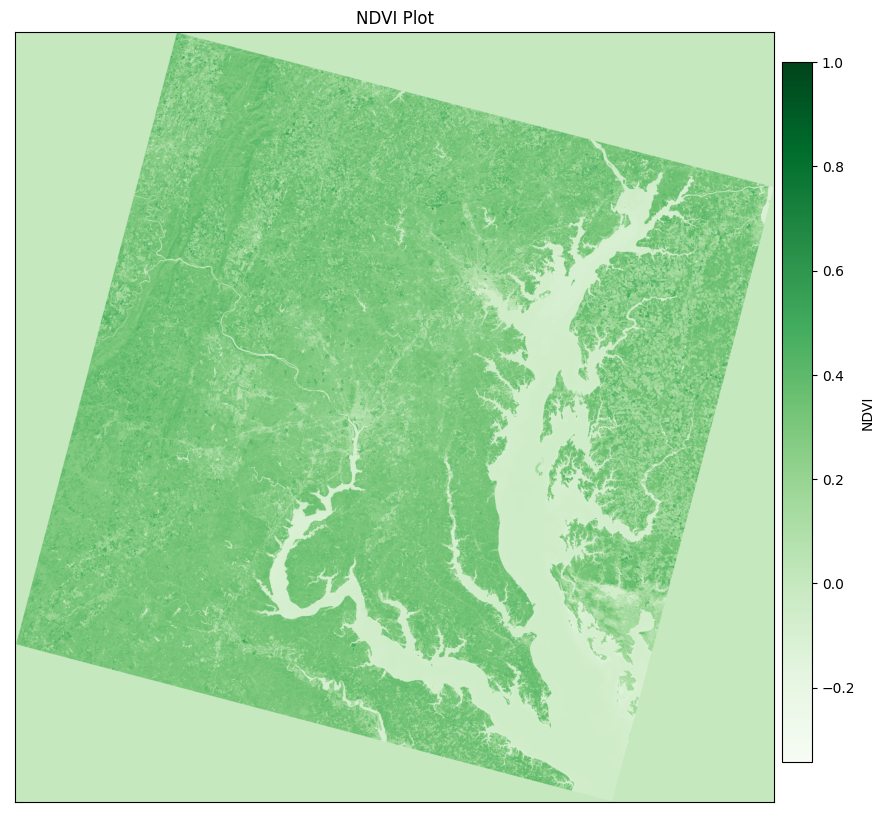

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# Remove the axes
ax.set_xticks([])
ax.set_yticks([])

# Set the color map to the min and max values of NDVI
ndvi_min, ndvi_max = np.min(ndvi), np.max(ndvi)
norm = colors.Normalize(vmin=ndvi_min, vmax=ndvi_max)

# Use the normalization object for the image and the color map
green_color_map = colormaps["Greens"]
green_ndvi = green_color_map(norm(ndvi))

img = ax.imshow(green_ndvi)
ax.set_title("NDVI Plot")

cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=green_color_map),
    cax=cax,
    orientation="vertical",
)
cb.set_label("NDVI")

plt.show()